In [1]:
%matplotlib notebook
import numpy as np
import pandas
import matplotlib.pyplot as plt

import sedkcorr.sed_fitting.prospector as sedp
from sedkcorr.k_correction import sed_lephare
from sedkcorr.k_correction import sed_prospector
from sedkcorr.k_correction.basesed import convert_flux_unit
import os
DATAPATH = os.path.expanduser(os.getenv('DATAPATH'))
LEPHAREDIR = os.path.expanduser(os.getenv('LEPHAREDIR'))

In [37]:
sn_name = "SNF20071015-000"
radius = "global"

spec_lephare = False

data = pandas.read_csv("SNf_mag_{}_prospector.dat".format(radius), sep=' ', index_col='SN_name')
test_data = data.loc[sn_name]
#test_data

lp_test = sed_lephare.SED_LePhare()

lp_test.set_data(sed_index=int(test_data["Unnamed: 0"]), sed_dir=LEPHAREDIR+"/data/SNf/spec_{}/".format(radius), 
                 data_meas=test_data)

/anaconda3/lib/python3.6/site-packages/sedkcorr-0.1.0-py3.6.egg/sedkcorr/k_correction/sed_lephare.py:76: FutureWarning: read_table is deprecated, use read_csv instead.


In [38]:
model_params="continuity_sfh" #parametric_sfh, continuity_sfh, continuity_flex_sfh, dirichlet_sfh, alpha

test = sedp.ProspectorSEDFitter()
test.set_run_params(mcmc="dynesty")#, do_levenberg=False, do_powell=True)
test.set_run_params(model_params=model_params)
test.set_run_params(add_dust=False)
test.set_run_params(outfile="SNf_"+radius+"_"+sn_name+"_sed_"+model_params)

In [39]:
test.load_sps()

In [40]:
if spec_lephare:
    test.load_obs(lp_test.data_sed, data_type="spec", 
                  zspec=test_data["Z-SPEC"], context_filters=test_data["CONTEXT"])
else:
    test.load_obs(test_data, data_type="phot", zspec=test_data["Z-SPEC"], context_filters=test_data["CONTEXT"])

In [41]:
test_priors = True

if test_priors:
    init_guess = {"logzsol":{"mean":-0.46493545, "sigma":0.7}, 
                  "dust2":{"mean":2.64467882, "sigma":0.7}, 
                  "logmass":{"mean":11.52924679, "sigma":1.}, 
                  "logsfr_ratios":{"mean":[1.25540323, -0.69562254], 
                                   "sigma":[2., 2.]}}
    test.load_model(imposed_priors=init_guess)
else:
    test.load_model()#(imposed_priors=None if spec_lephare else init_guess)

In [42]:
test.run_fit(write_res=False)

dynesty sampling...


iter: 2 | batch: 0 | nc: 1 | ncall: 2 | eff(%):  1.961 | logz: -4813030266848710.000 +/- 3612898.801 | dlogz:    inf >  0.050    /anaconda3/lib/python3.6/site-packages/prospect-0.3.0-py3.6.egg/prospect/fitting/nested.py:76: RuntimeWarning: invalid value encountered in sqrt
  logzerr = np.sqrt(logzvar)
iter: 350 | batch: 0 | nc: 40 | ncall: 3427 | eff(%):  9.923 | logz: -702638781.499 +/-  0.502 | dlogz:    inf >  0.050          /anaconda3/lib/python3.6/site-packages/prospect-0.3.0-py3.6.egg/prospect/fitting/nested.py:76: RuntimeWarning: invalid value encountered in sqrt
  logzerr = np.sqrt(logzvar)
iter: 362 | batch: 0 | nc: 6 | ncall: 3492 | eff(%): 10.078 | logz: -573056040.982 +/-  0.539 | dlogz:    inf >  0.050     /anaconda3/lib/python3.6/site-packages/prospect-0.3.0-py3.6.egg/prospect/fitting/nested.py:76: RuntimeWarning: invalid value encountered in sqrt
  logzerr = np.sqrt(logzvar)
iter: 381 | batch: 0 | nc: 5 | ncall: 3604 | eff(%): 10.286 | logz: -487845711.018 +/-  0.129 | d


done dynesty (initial) in 7356.069498062134s
done dynesty (dynamic) in 15.26321005821228s
done dynesty in 7373.886593818665s


In [43]:
test.write_results()

/anaconda3/lib/python3.6/site-packages/prospect-0.3.0-py3.6.egg/prospect/io/write_results.py:52: RuntimeWarning: Could not store paramfile text
/anaconda3/lib/python3.6/site-packages/prospect-0.3.0-py3.6.egg/prospect/io/write_results.py:225: RuntimeWarning: Could not JSON serialize run_params, pickled instead
/anaconda3/lib/python3.6/site-packages/prospect-0.3.0-py3.6.egg/prospect/io/write_results.py:225: RuntimeWarning: Could not JSON serialize model_params, pickled instead


In [11]:
testres = sed_prospector.SED_prospector()

In [15]:
filename = "SNf_"+radius+"_"+sn_name+"_sed_"+model_params
#filename = "/Users/mart1/Desktop/DATA/SED_prospector/spec_fit/SNf_{}_{}_sed_{}".format(radius, sn_name, model_params)
testres.set_data(filename=filename+"_mcmc_dynesty.h5", 
                 data_meas=test_data, sps=test.sps)#, nb_walkers_points=1000)

<IPython.core.display.Javascript object>


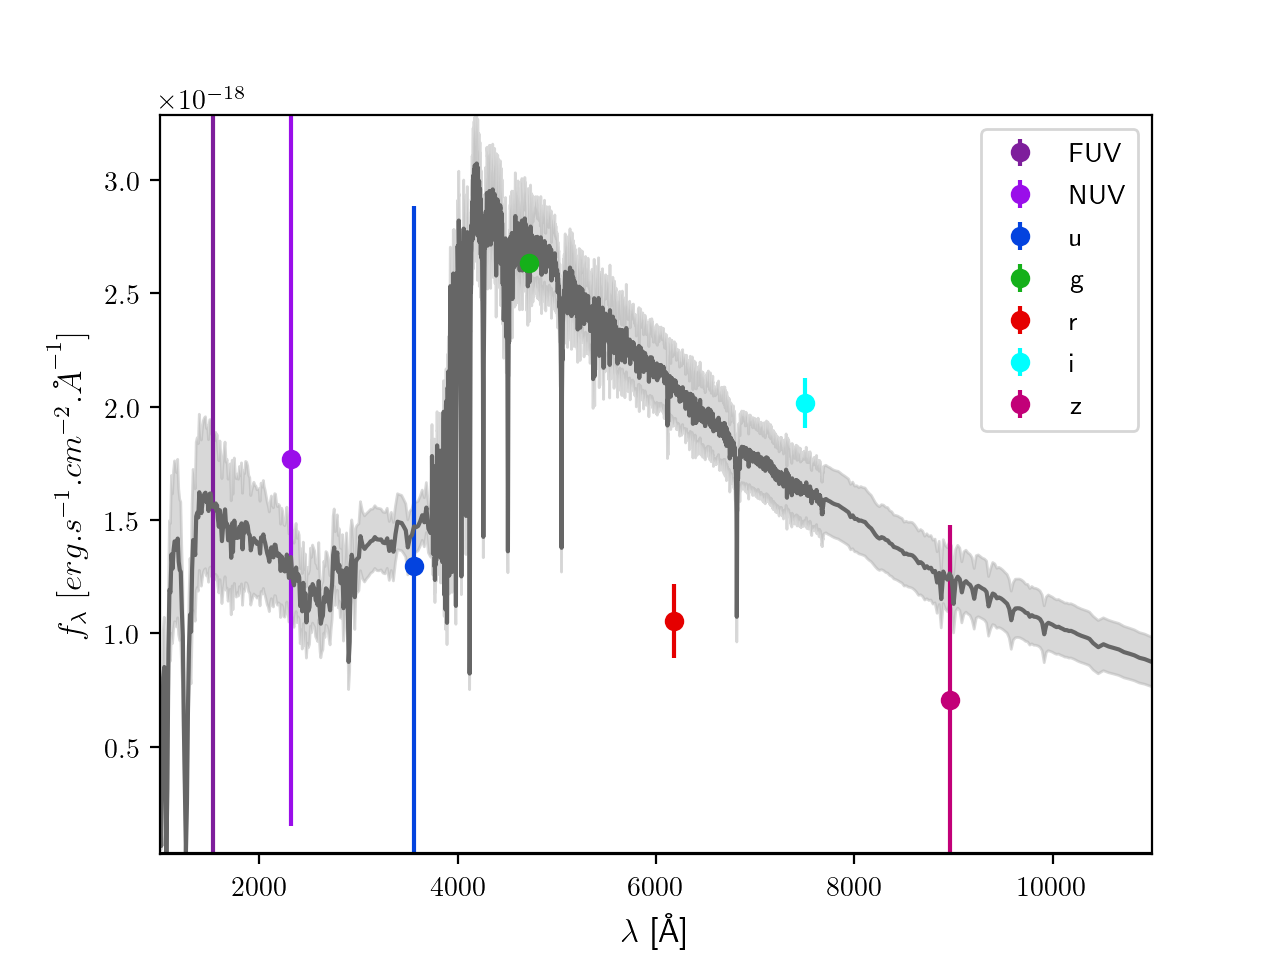

In [16]:
dict_fig = testres.show(y_plot="flux", sed_shifted=False, plot_bandpasses=False, plot_filter_points=True, 
                        xlim=(1000, 11000), ylim=(None, None), savefile=None, xscale="linear", yscale="linear", 
                        flux_unit="AA")
dict_fig["ax"].legend(loc="upper right", ncol=1)

<IPython.core.display.Javascript object>


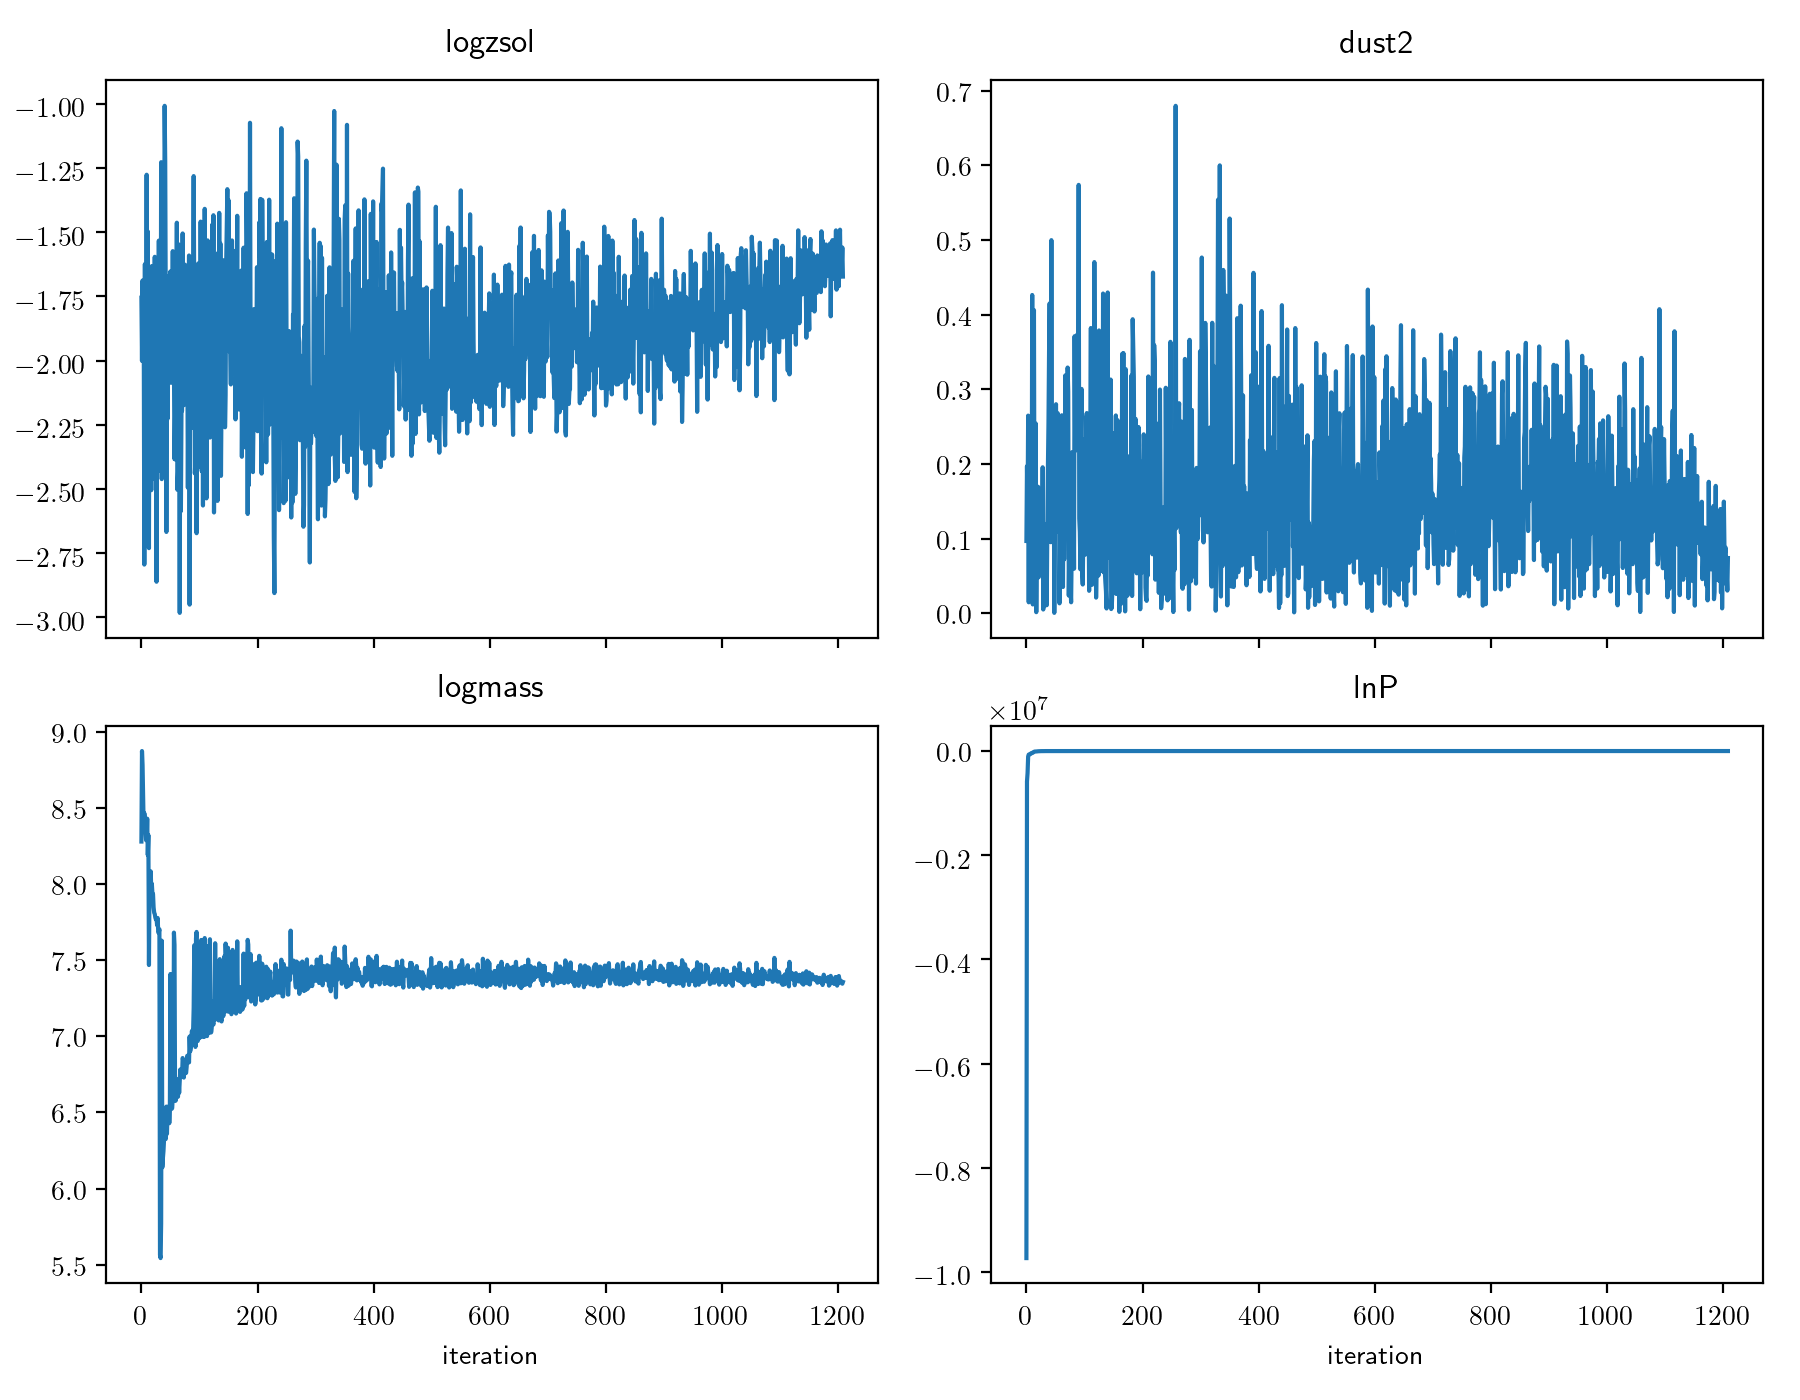

<IPython.core.display.Javascript object>


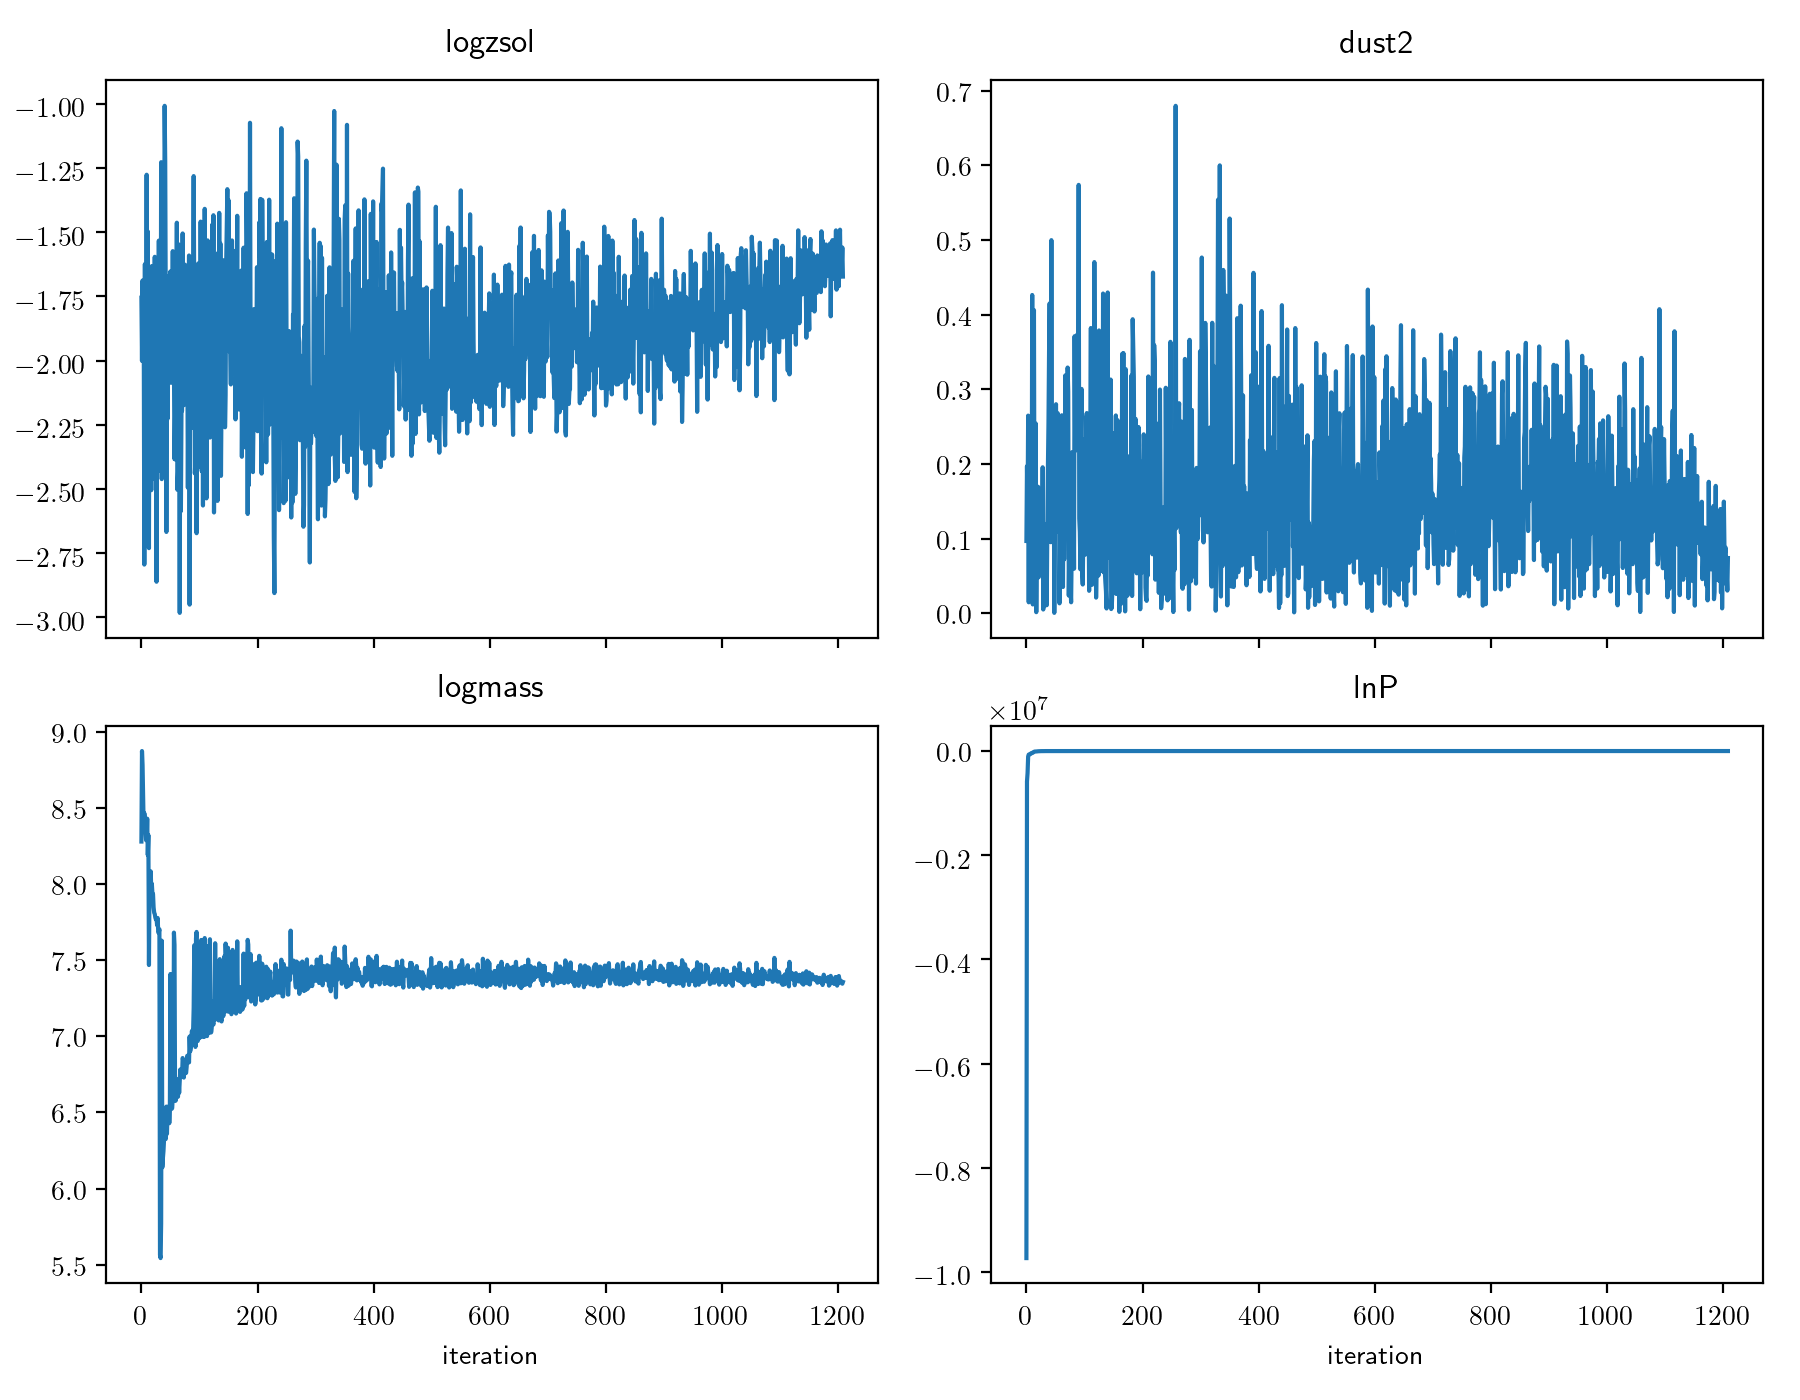

In [17]:
testres.show_walkers(showpars=["logzsol", "dust2", "logmass"])

<IPython.core.display.Javascript object>


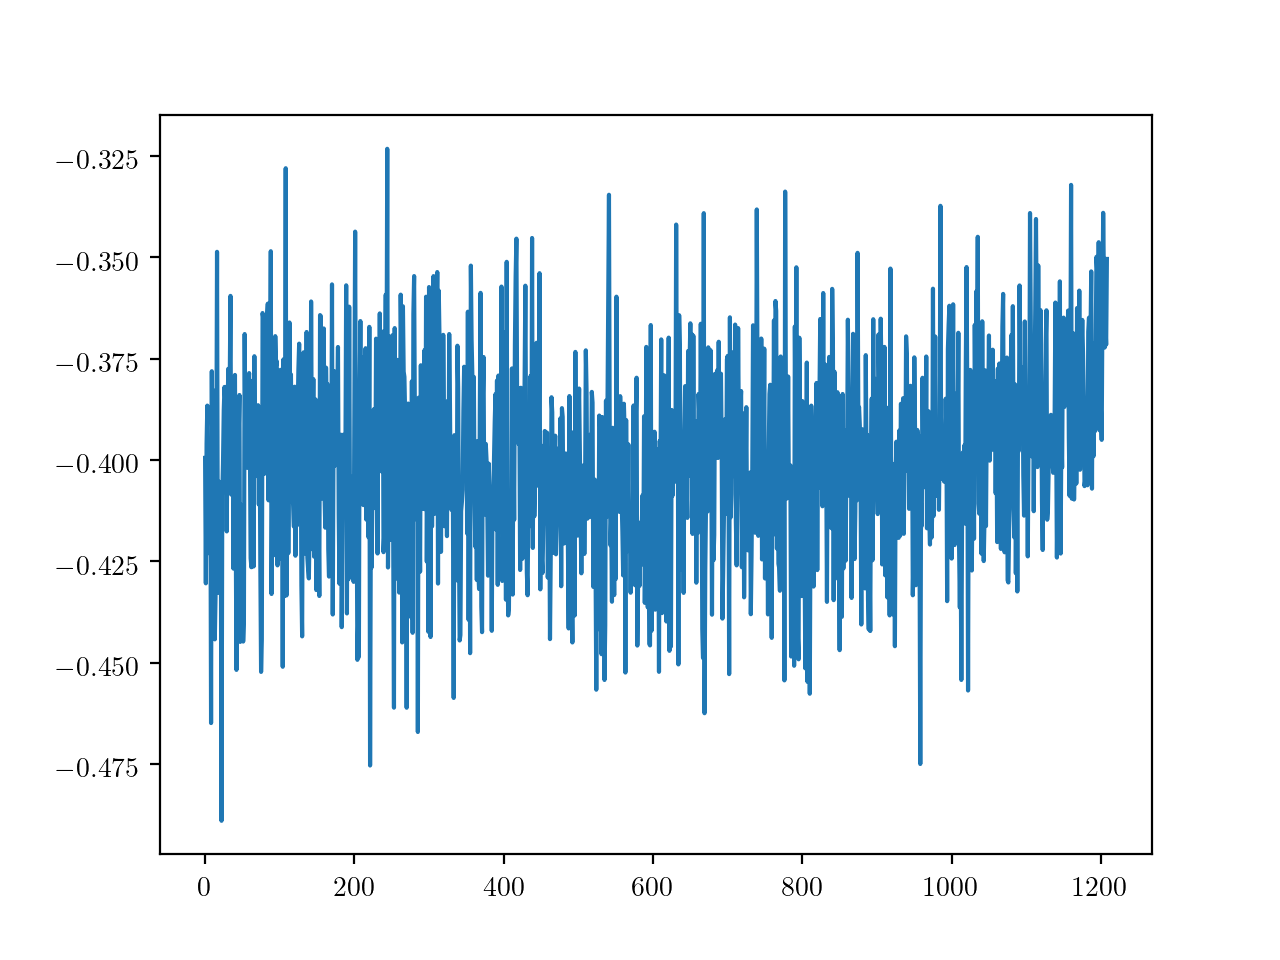

In [18]:
fig, ax = plt.subplots()
ax.plot(testres.p_res["chain"][:,-1])

<IPython.core.display.Javascript object>


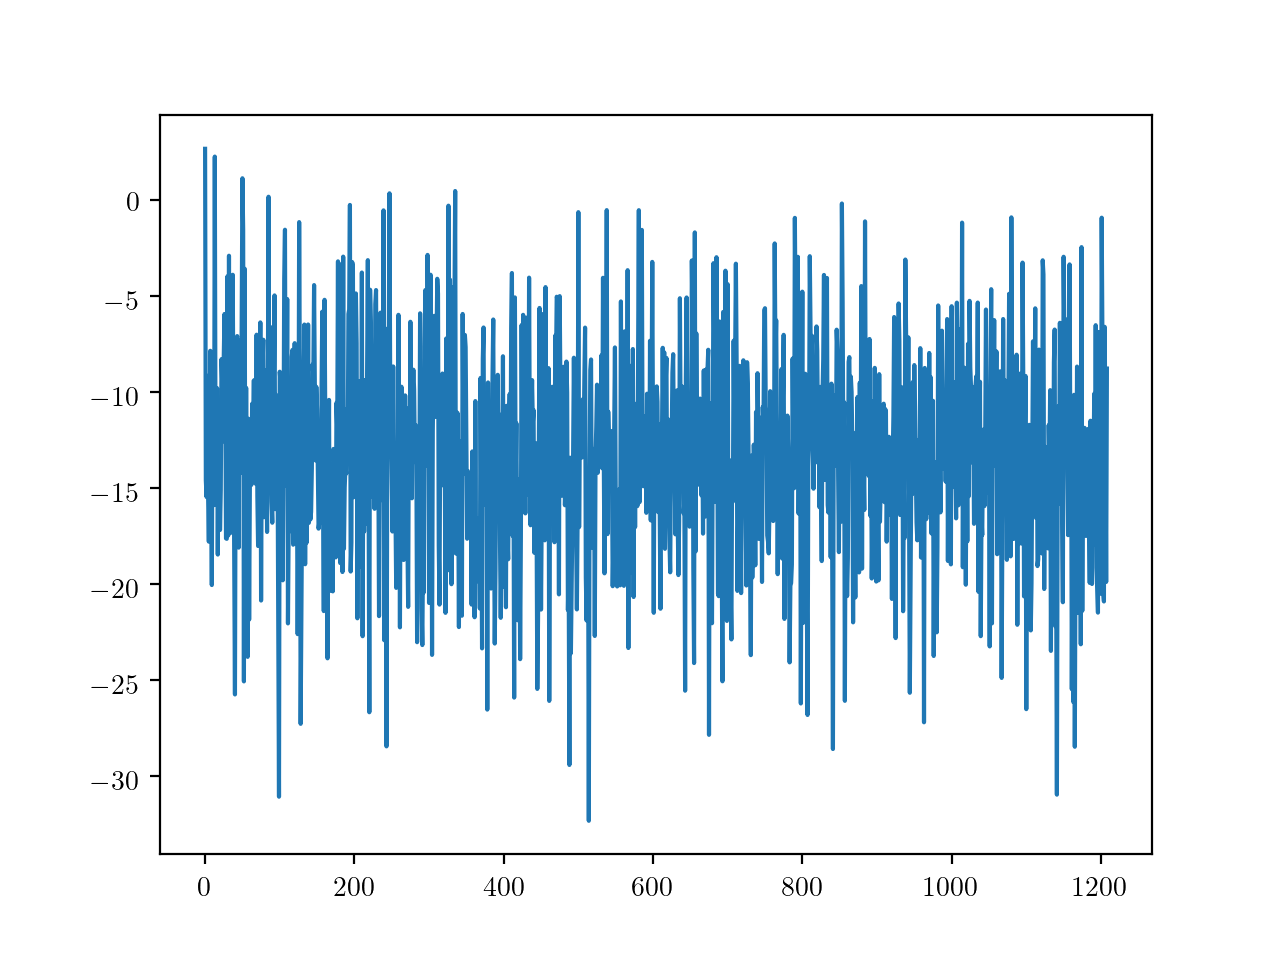

In [19]:
fig, ax = plt.subplots()
ax.plot(testres.p_res["chain"][:,-2])

In [80]:
from prospect.utils.plotting import quantile
post_pcts = [quantile(testres.p_res["chain"][3000:, i], percents=[16, 50, 84])
             for i in range(testres.p_mod.ndim)]
post_pcts

[array([-0.46419061, -0.46101471, -0.45836286]),
 array([0.00273473, 0.00290227, 0.00305917]),
 array([9.34642   , 9.34729452, 9.34843481]),
 array([-3.49020112, -3.48503375, -3.48024655]),
 array([0.28481298, 0.28858279, 0.29181137])]

In [81]:
list_param = ["logzsol", "dust2", "logmass"]
init_guess = {elt:{"mean":post_pcts[ii][1], "sigma":((post_pcts[ii][2]-post_pcts[ii][0])/2)*10} 
              for ii, elt in enumerate(list_param)}
init_guess["logsfr_ratios"] = {"mean":[post_pcts[3][1], post_pcts[4][1]], 
                               "sigma": [((post_pcts[3][2]-post_pcts[3][0])/2)*10, 
                                         ((post_pcts[4][2]-post_pcts[4][0])/2)*10]}
init_guess["logmass"]["sigma"] *= 20
init_guess

{'logzsol': {'mean': -0.4610147063446379, 'sigma': 0.029138746578749597},
 'dust2': {'mean': 0.0029022707384637474, 'sigma': 0.0016222026441036147},
 'logmass': {'mean': 9.347294519271472, 'sigma': 0.20148115983449344},
 'logsfr_ratios': {'mean': [-3.4850337549024624, 0.28858278955288463],
  'sigma': [0.04977284742260002, 0.03499193855659277]}}

In [12]:
testres.post_pcts

[array([-0.38072034, -0.38024846, -0.37978247]),
 array([0.00845209, 0.00849115, 0.0085307 ]),
 array([9.53570531, 9.53590409, 9.53611118]),
 array([-3.75305751, -3.75115279, -3.74919028]),
 array([0.24894348, 0.24951327, 0.25015633])]

In [30]:
for pcts in testres.post_pcts:
    print(pcts[1]-pcts[0], pcts[2]-pcts[1], (((pcts[1]-pcts[0])+(pcts[2]-pcts[1]))/2)*1000)

0.0004342352910197689 0.0005552846777931997 0.4947599844064843
4.024975766540959e-05 3.887844267182888e-05 0.039564100168619235
0.0001957343735270456 0.0001888562742973221 0.19229532391218385
0.0018292098277390423 0.0019634424138872397 1.896326120813141
0.0005552014363392477 0.0006282583706654354 0.5917299035023416


In [16]:
testres.post_pcts

[array([-0.37943633, -0.37900676, -0.37854703]),
 array([0.00760948, 0.00764599, 0.00768537]),
 array([9.53558179, 9.53577902, 9.5359624 ]),
 array([-3.76006839, -3.75804333, -3.75617986]),
 array([0.2489715 , 0.24953902, 0.25011064])]

In [47]:
np.log10(6.38072686e+08)

8.804870154161067

In [104]:
testsfr.shape

(8905,)

In [31]:
testsfr = ((testres.p_res["chain"][:,-1]+testres.p_res["chain"][:,-2]+testres.p_res["chain"][:,-3]) 
           - testres.p_res["chain"][:,2])

<IPython.core.display.Javascript object>


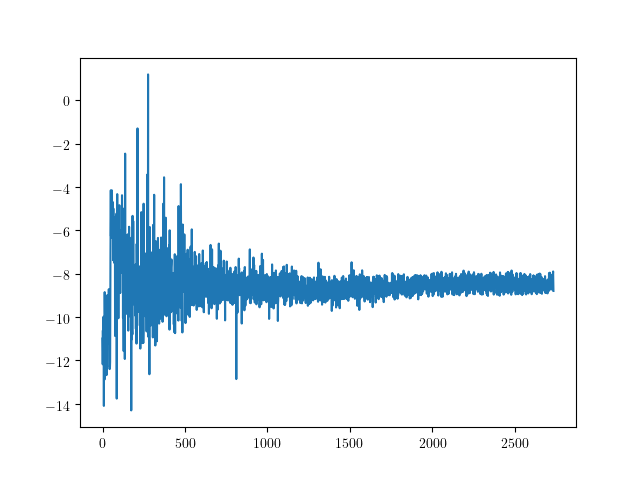

In [32]:
fig, ax = plt.subplots()
ax.plot(testsfr)
#ax.set_yscale("log")

In [28]:
testres.p_res

{'model_params': [{'N': 1,
   'isfree': False,
   'init': 0.037241960987646434,
   'units': 'redshift',
   'prior': b'\x80\x02cprospect.models.priors\nTopHat\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06uX\x06\x00\x00\x00paramsq\x07}q\x08(h\x05G\x00\x00\x00\x00\x00\x00\x00\x00h\x06G@\x10\x00\x00\x00\x00\x00\x00uX\x04\x00\x00\x00nameq\tX\x00\x00\x00\x00q\nub.',
   'name': 'zred'},
  {'N': 4,
   'isfree': False,
   'init': 1000000.0,
   'units': 'M$_\\odot$',
   'depends_on': ['logsfr_ratios_to_masses_flex',
    'prospect.models.transforms'],
   'name': 'mass'},
  {'N': 1,
   'isfree': True,
   'init': -0.3,
   'units': '$\\log (Z/Z_\\odot)$',
   'prior': b'\x80\x02cprospect.models.priors\nTopHat\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06uX\x06\x00\x00\x00paramsq\x07}q\x08(h\x05G\xc0\x00\x00\x00\x00\x00\x00\x00h\x06G@\x00\x00\x00\x00\x00\x

In [30]:
from prospect.io.read_results import traceplot

<IPython.core.display.Javascript object>


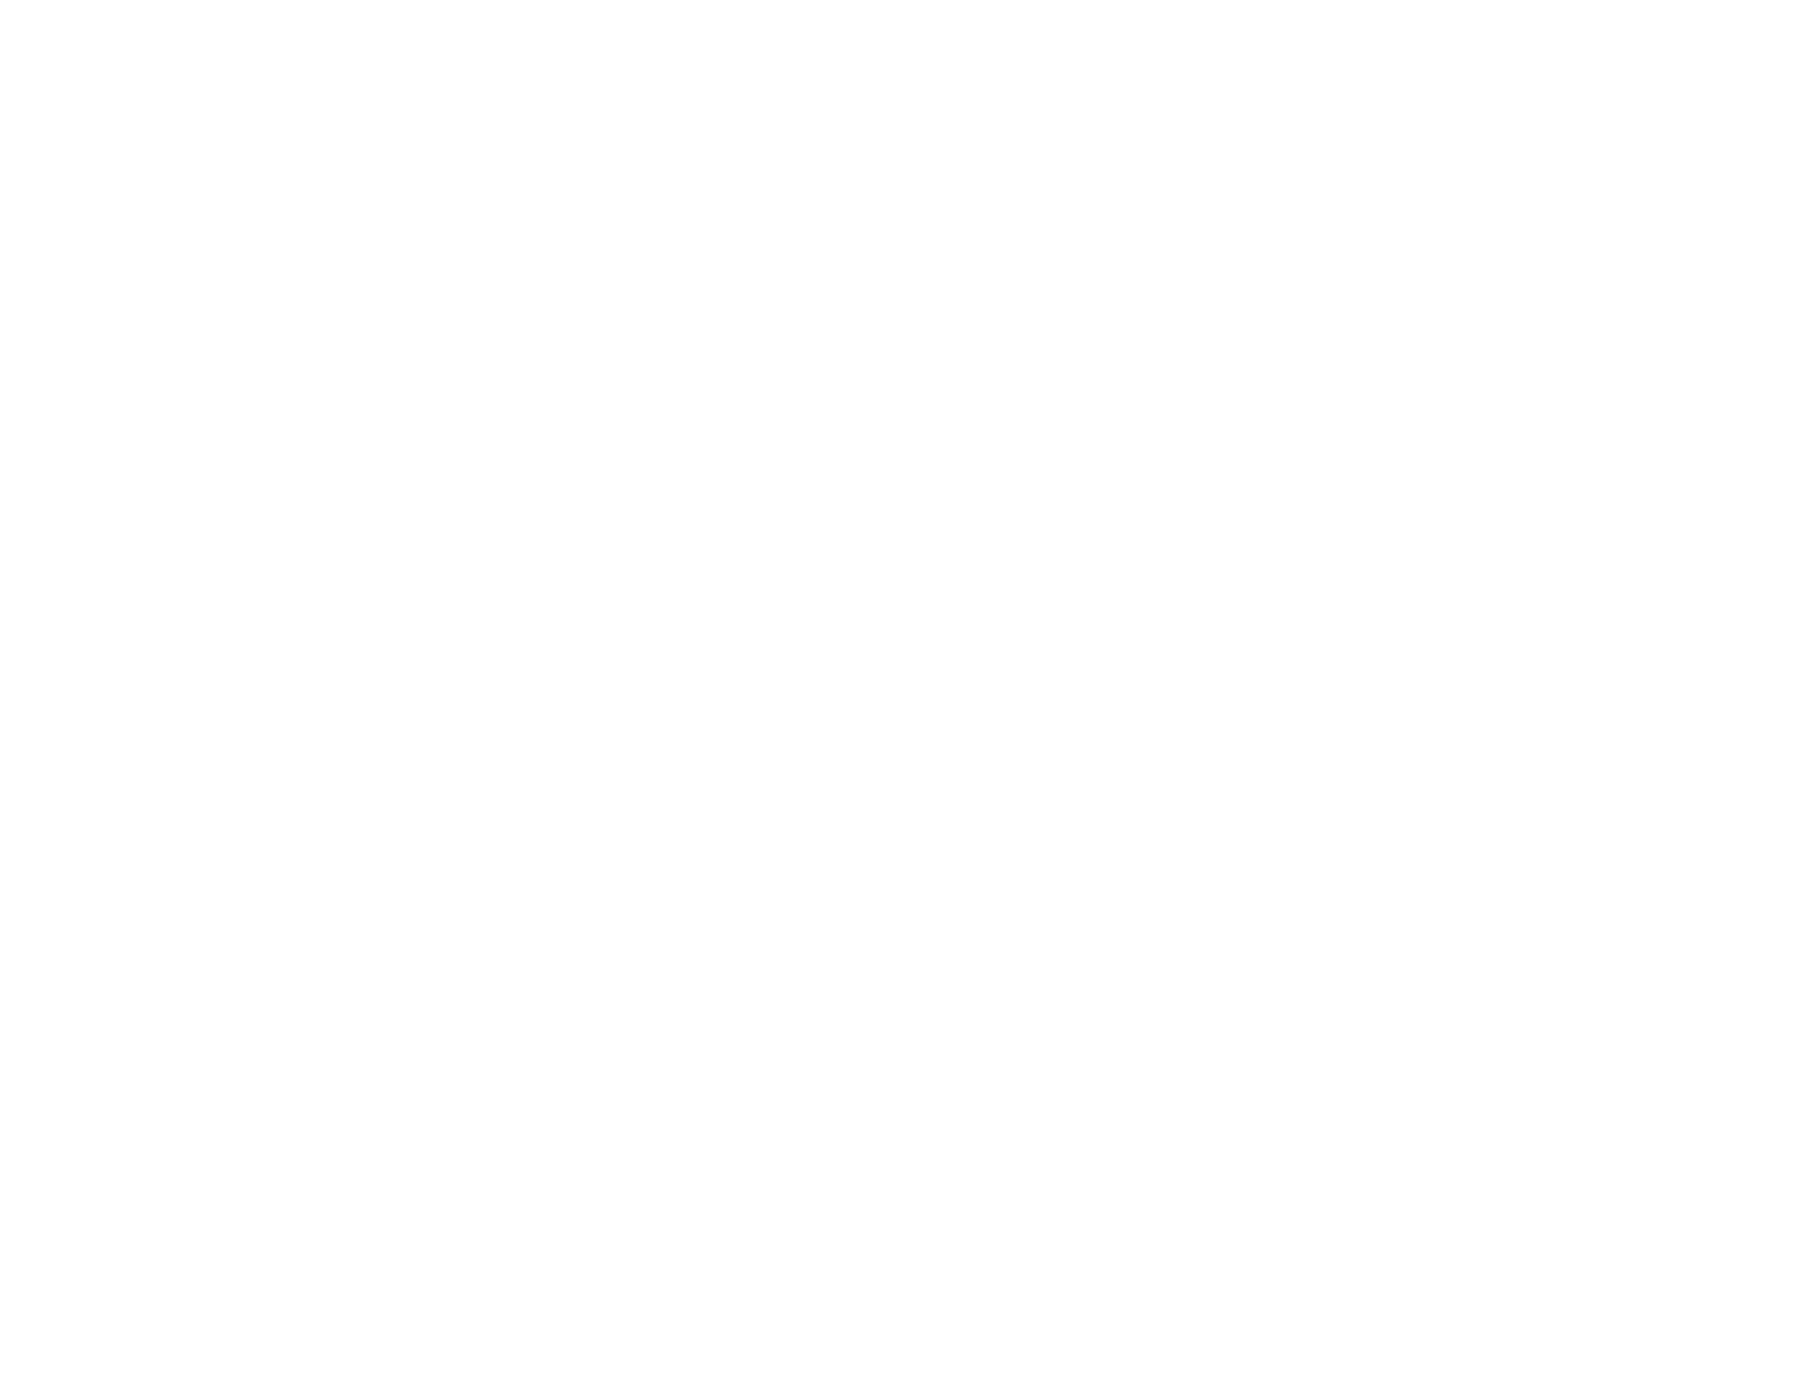

RuntimeError: latex was not able to process the following string:
b'logsfr_ratios_1'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/mart1/.matplotlib/tex.cache/f08bebe17a7a14b67f2b26fef5b355eb.tex
LaTeX2e <2018-04-01> patch level 2
Babel <3.18> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2018/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2018/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2018/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2018/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2018/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2018/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./f08bebe17a7a14b67f2b26fef5b355eb.aux)
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...ze{12.000000}{15.000000}{\sffamily logsfr_
                                                  ratios_1}
No pages of output.
Transcript written on f08bebe17a7a14b67f2b26fef5b355eb.log.




In [43]:
traceplot(testres.p_res, showpars=["logsfr_ratios_1", "logzsol", "dust2", "logmass"], figsize=(9,7), )

In [11]:
np.array(testres.sed_stack)[:,0].shape

(1000,)

In [12]:
testres.read_fit_results(filename="test_snf_"+sn_name+"_mcmc_emcee.h5")

In [14]:
testres.p_res

{'model_params': [{'N': 1,
   'isfree': False,
   'init': 0.0751692404399864,
   'units': 'redshift',
   'prior': b'\x80\x02cprospect.models.priors\nTopHat\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06uX\x06\x00\x00\x00paramsq\x07}q\x08(h\x05G\x00\x00\x00\x00\x00\x00\x00\x00h\x06G@\x10\x00\x00\x00\x00\x00\x00uX\x04\x00\x00\x00nameq\tX\x00\x00\x00\x00q\nub.',
   'name': 'zred'},
  {'N': 3,
   'isfree': False,
   'init': 1000000.0,
   'units': 'M$_\\odot$',
   'depends_on': ['logsfr_ratios_to_masses', 'prospect.models.transforms'],
   'name': 'mass'},
  {'N': 1,
   'isfree': True,
   'init': -0.3,
   'units': '$\\log (Z/Z_\\odot)$',
   'prior': b'\x80\x02cprospect.models.priors\nTopHat\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06uX\x06\x00\x00\x00paramsq\x07}q\x08(h\x05G\xc0\x00\x00\x00\x00\x00\x00\x00h\x06G@\x00\x00\x00\x00\x00\x00\x00uX\x0

In [27]:
testc = testres.p_res["chain"]

In [34]:
testc[[0,2],[1,3],:].shape

(2, 5)

In [ ]:
np.random.randint()

In [9]:
testres.sed_stack.shape

(500, 5994)

In [16]:
testkcorr = testres.get_kcorr_error()

In [33]:
np.mean(testsfr, axis=0, )

-10.234306089690929

<IPython.core.display.Javascript object>


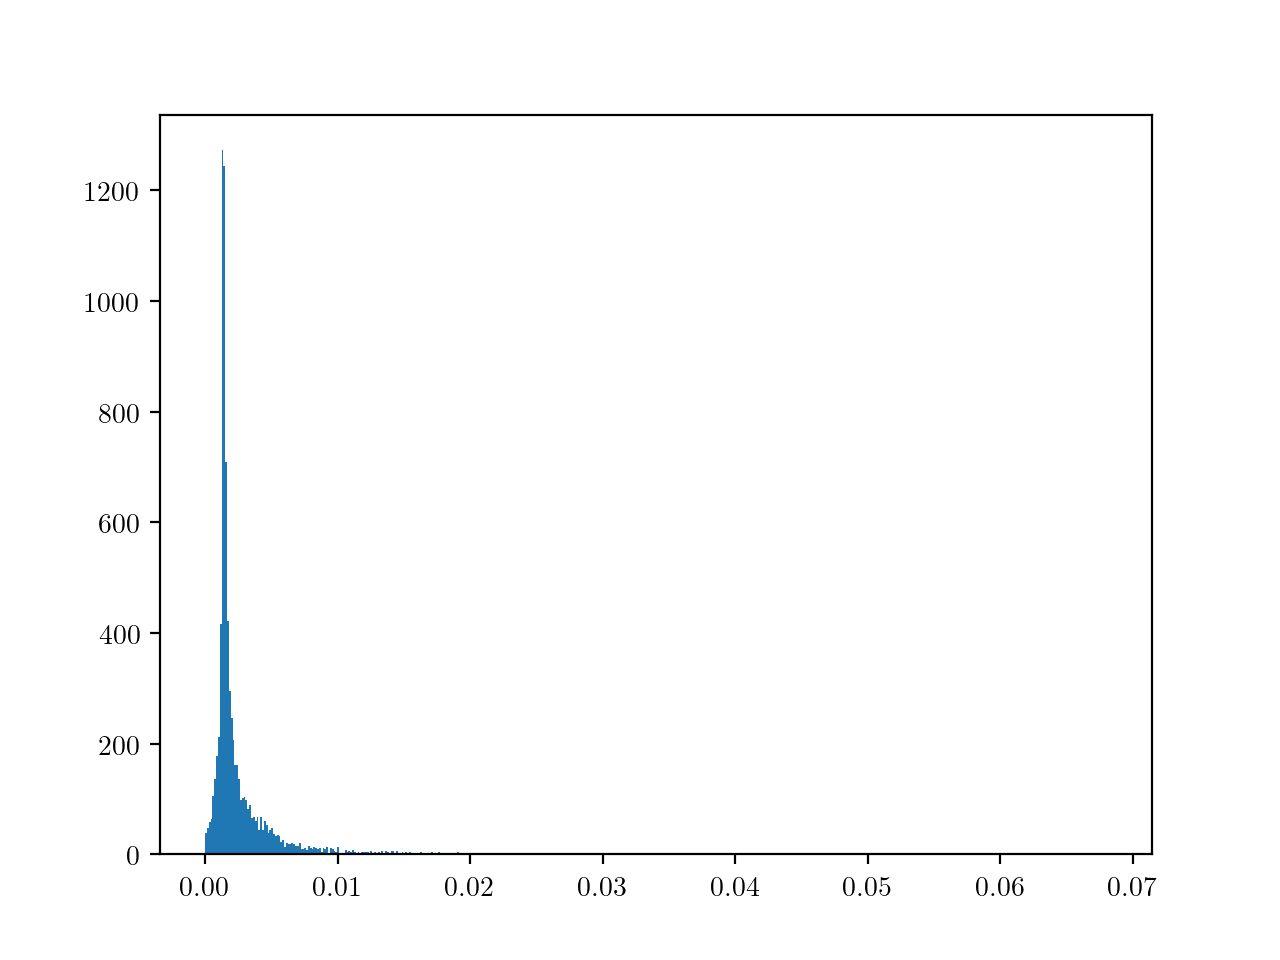

(array([3.800e+01, 4.800e+01, 5.900e+01, 6.400e+01, 1.060e+02, 1.360e+02,
        1.770e+02, 2.130e+02, 4.160e+02, 1.272e+03, 1.243e+03, 7.090e+02,
        4.210e+02, 2.960e+02, 2.470e+02, 2.060e+02, 1.610e+02, 1.620e+02,
        1.370e+02, 9.800e+01, 1.020e+02, 1.030e+02, 9.800e+01, 8.200e+01,
        9.000e+01, 6.500e+01, 6.800e+01, 6.100e+01, 6.800e+01, 4.400e+01,
        6.800e+01, 4.400e+01, 6.100e+01, 5.400e+01, 3.800e+01, 4.400e+01,
        4.700e+01, 3.700e+01, 3.300e+01, 3.500e+01, 3.300e+01, 2.300e+01,
        2.600e+01, 1.400e+01, 2.100e+01, 1.800e+01, 1.800e+01, 2.000e+01,
        1.800e+01, 1.500e+01, 1.600e+01, 2.000e+01, 9.000e+00, 1.000e+01,
        1.200e+01, 8.000e+00, 1.500e+01, 1.100e+01, 1.000e+01, 1.300e+01,
        1.100e+01, 9.000e+00, 1.100e+01, 4.000e+00, 1.100e+01, 9.000e+00,
        1.300e+01, 3.000e+00, 1.200e+01, 9.000e+00, 6.000e+00, 5.000e+00,
        1.300e+01, 0.000e+00, 3.000e+00, 3.000e+00, 8.000e+00, 4.000e+00,
        7.000e+00, 5.000e+00, 8.000e+0

In [23]:
fig, ax = plt.subplots()
ax.hist(testres.p_res["chain"][:,1][3000:], bins="auto")

In [23]:
np.mean(testkcorr, axis=0)

array([4.36317990e-29, 5.13969792e-29, 7.13911096e-29, 1.77336015e-28,
       2.40339115e-28, 2.90015988e-28, 3.66581892e-28])

In [24]:
testres.data_kcorr

{'FUV': {'flux': 4.074852076849915e-29,
  'mag': (22.404181811455977, 0.0),
  'mag.err': 1.0428544907904804,
  'flux.err': 1.5649681924407176e-29},
 'NUV': {'flux': 4.619152960246324e-29,
  'mag': (22.33490320922005, 0.0),
  'mag.err': 0.025681339628858883,
  'flux.err': 3.1390632169113464e-32},
 'u': {'flux': 7.031193709060348e-29,
  'mag': (21.80884516108383, 0.0),
  'mag.err': 0.5535039144779947,
  'flux.err': 2.274681675717461e-29},
 'g': {'flux': 1.659279917604633e-28,
  'mag': (20.812398987094028, 0.0),
  'mag.err': 0.07850827401142979,
  'flux.err': 8.612673194374014e-31},
 'r': {'flux': 2.205646126899124e-28,
  'mag': (20.51830717341379, 0.0),
  'mag.err': 0.07809008744012047,
  'flux.err': 1.37065282391698e-30},
 'i': {'flux': 2.7279899322782395e-28,
  'mag': (20.26364765160946, 0.0),
  'mag.err': 0.09397498540695892,
  'flux.err': 2.5579004607034792e-30},
 'z': {'flux': 3.471968807842956e-28,
  'mag': (20.013291092244895, 0.0),
  'mag.err': 0.2231178828343161,
  'flux.err': 2

In [7]:
"Hz" in ("Hz", "Herz")

True

In [8]:
from astropy import units

In [9]:
test = 12
testu = units.m

In [12]:
test *= 2 * testu * units.s 

UnitTypeError: Cannot store quantity with dimension resulting from multiply function in a non-Quantity instance.

In [18]:
test = np.array([1, 2, 3, 4])

In [19]:
test = 2 * test * testu * units.s 
test

<Quantity [2., 4., 6., 8.] m s>

In [15]:
testres.p_res

{'model_params': [{'N': 1,
   'isfree': False,
   'init': 0.0751692404399864,
   'units': 'redshift',
   'prior': b'\x80\x02cprospect.models.priors\nTopHat\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06uX\x06\x00\x00\x00paramsq\x07}q\x08(h\x05G\x00\x00\x00\x00\x00\x00\x00\x00h\x06G@\x10\x00\x00\x00\x00\x00\x00uX\x04\x00\x00\x00nameq\tX\x00\x00\x00\x00q\nub.',
   'name': 'zred'},
  {'N': 3,
   'isfree': False,
   'init': 1000000.0,
   'units': 'M$_\\odot$',
   'depends_on': ['logsfr_ratios_to_masses', 'prospect.models.transforms'],
   'name': 'mass'},
  {'N': 1,
   'isfree': True,
   'init': -0.3,
   'units': '$\\log (Z/Z_\\odot)$',
   'prior': b'\x80\x02cprospect.models.priors\nTopHat\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06uX\x06\x00\x00\x00paramsq\x07}q\x08(h\x05G\xc0\x00\x00\x00\x00\x00\x00\x00h\x06G@\x00\x00\x00\x00\x00\x00\x00uX\x0

In [18]:
len(testres.get_sed_wavelength())

5994

In [19]:
len(testres.data_sed)

5994

In [21]:
testres.p_res["chain"][-1000:, :].shape

(1000, 5)

In [6]:
test = testres.get_sed_error()

TypeError: Required argument 'object' (pos 1) not found

In [50]:
theta = testres.p_res["chain"][-500:, :]
mspec = np.empty((500, len(testres.get_sed_wavelength())))
for ii in range(500):
    mspec[ii], _, _ = testres.p_mod.mean_model(theta[ii], testres.p_obs, sps=testres.p_sps)

In [20]:
testres.post_pcts

[array([-0.73636075, -0.73589681, -0.73563215]),
 array([0.00130218, 0.00137995, 0.00149574]),
 array([9.91321654, 9.91324336, 9.91328373]),
 array([0.35782564, 0.35839212, 0.35938636]),
 array([-0.71412318, -0.7131353 , -0.71257018])]

In [21]:
testres.sed_stack[:, 2]

array([1.08993848e-12, 1.08937721e-12, 1.08927566e-12, 1.08854854e-12,
       1.08883878e-12, 1.09055781e-12, 1.09085081e-12, 1.09064365e-12,
       1.09008092e-12, 1.09104163e-12, 1.09043264e-12, 1.09040439e-12,
       1.09036411e-12, 1.09054120e-12, 1.09112981e-12, 1.09050416e-12,
       1.08990042e-12, 1.09101309e-12, 1.09119226e-12, 1.08881903e-12,
       1.09113880e-12, 1.08866044e-12, 1.08932117e-12, 1.09054932e-12,
       1.08905217e-12, 1.08963339e-12, 1.09061264e-12, 1.08920845e-12,
       1.09061633e-12, 1.08979202e-12, 1.09001806e-12, 1.09094312e-12,
       1.09067526e-12, 1.09110262e-12, 1.09123375e-12, 1.09007042e-12,
       1.09069957e-12, 1.08854130e-12, 1.09047483e-12, 1.08963772e-12,
       1.08959312e-12, 1.09126334e-12, 1.08866128e-12, 1.08897399e-12,
       1.08841581e-12, 1.09012908e-12, 1.09096772e-12, 1.09068119e-12,
       1.09037033e-12, 1.08833299e-12, 1.09060969e-12, 1.08978060e-12,
       1.08998575e-12, 1.08965573e-12, 1.09109577e-12, 1.09064603e-12,
      

<IPython.core.display.Javascript object>


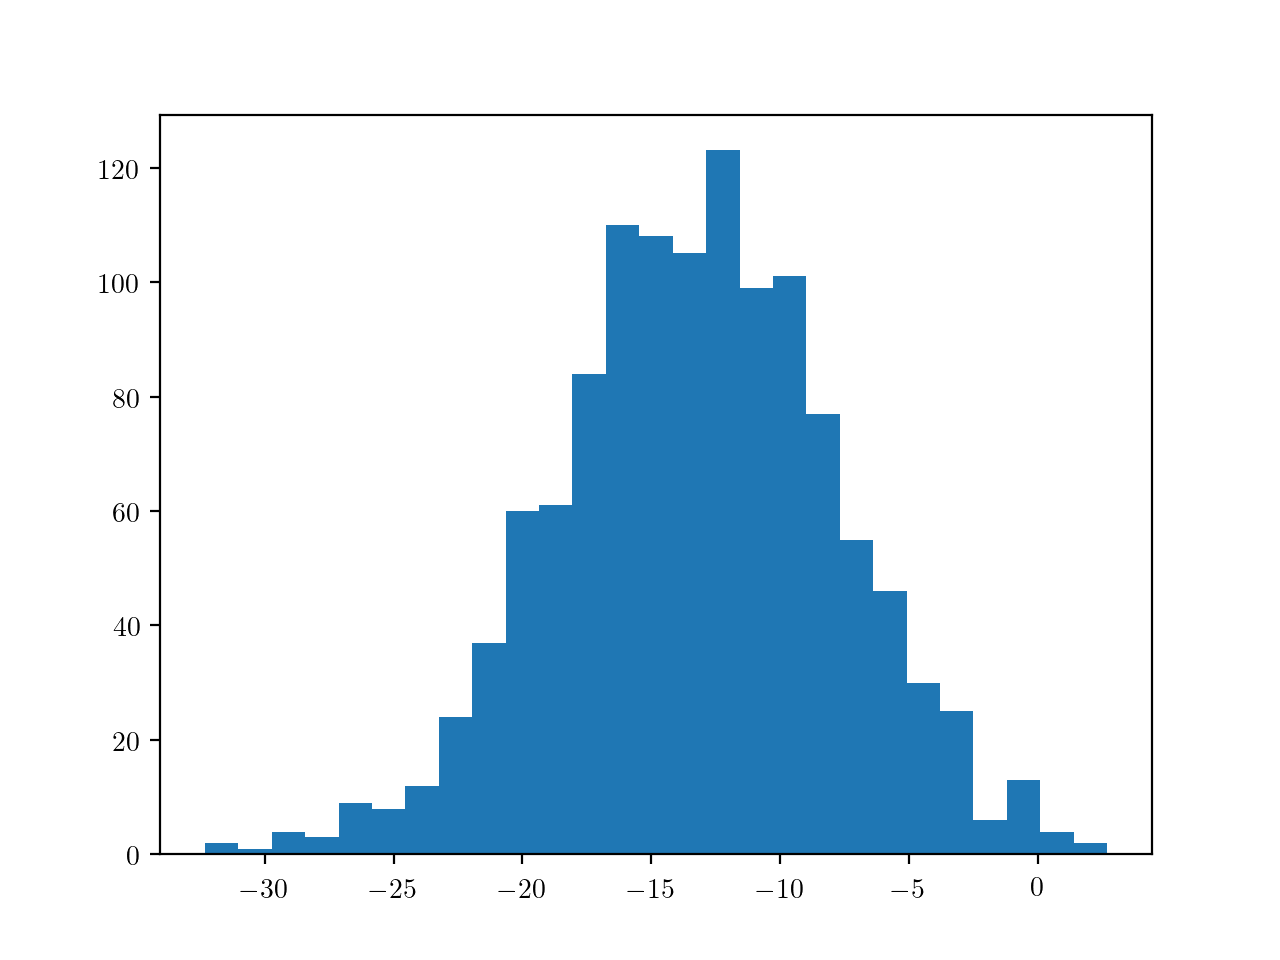

(array([  2.,   1.,   4.,   3.,   9.,   8.,  12.,  24.,  37.,  60.,  61.,
         84., 110., 108., 105., 123.,  99., 101.,  77.,  55.,  46.,  30.,
         25.,   6.,  13.,   4.,   2.]),
 array([-32.31473017, -31.01878047, -29.72283076, -28.42688106,
        -27.13093136, -25.83498165, -24.53903195, -23.24308225,
        -21.94713254, -20.65118284, -19.35523314, -18.05928343,
        -16.76333373, -15.46738403, -14.17143432, -12.87548462,
        -11.57953492, -10.28358521,  -8.98763551,  -7.69168581,
         -6.3957361 ,  -5.0997864 ,  -3.8038367 ,  -2.50788699,
         -1.21193729,   0.08401241,   1.37996212,   2.67591182]),
 <a list of 27 Patch objects>)

In [21]:
fig, ax = plt.subplots()
ax.hist(testres.p_res["chain"][:, -2], bins="auto")

In [34]:
np.mean(testres.sed_stack[:, 1001], axis=0)

2.91793501321989e-07

In [41]:
mspec.shape

(100, 5994)

In [22]:
theta = []
randint = np.random.randint
while len(theta) < 500:
    rand_iter = randint(len(testres.p_res["chain"]))
    buf_theta = testres.p_res["chain"][rand_iter, :]
    print(buf_theta)
    if np.prod([testres.post_pcts[ii][0]<elt<testres.post_pcts[ii][2] for ii, elt in enumerate(buf_theta)]):
        theta.append(buf_theta)

[-7.44459598e-01  3.98372888e-03  9.91084207e+00  2.54608981e-01
 -6.32261291e-01]
[-0.73986563  0.01039696  9.91035293  0.17661779 -0.56399694]
[-0.71608313  0.01493817  9.91390101  0.24067196 -0.5958566 ]
[-7.36780072e-01  1.65161562e-03  9.91331411e+00  3.60551687e-01
 -7.15047710e-01]
[-7.36581888e-01  1.55985665e-03  9.91332519e+00  3.60057877e-01
 -7.14804183e-01]
[-1.7543196   1.40982511 10.25361249 -0.02803337  0.36532489]
[-7.32300591e-01  1.94102302e-03  9.91330846e+00  3.52258667e-01
 -7.05449139e-01]
[-7.34757973e-01  1.56429810e-03  9.91326757e+00  3.56858401e-01
 -7.10967833e-01]
[-0.7339602   0.010092    9.91376198  0.30600045 -0.66020242]
[-7.36289665e-01  1.60325085e-03  9.91332472e+00  3.59649598e-01
 -7.14218596e-01]
[-7.36210773e-01  1.28606305e-03  9.91322047e+00  3.58634794e-01
 -7.13626653e-01]
[-0.76959732  0.04716878  9.91960684  0.20943994 -0.56452736]
[-7.35646255e-01  1.66774799e-03  9.91331378e+00  3.58626367e-01
 -7.12850006e-01]
[-7.33072662e-01  1.747088

 -7.14348882e-01]
[-7.35781993e-01  1.28651783e-03  9.91321497e+00  3.58078792e-01
 -7.12886970e-01]
[-1.21829321  0.29714717  9.9960449  -0.02023613 -0.42203308]
[-0.8022364   0.04394454  9.92271499  0.28090471 -0.64390256]
[-1.50469124  0.52771592 10.07149139  0.03889447 -0.35013248]
[-7.36260587e-01  2.19429697e-03  9.91352631e+00  3.60489004e-01
 -7.14484675e-01]
[-7.36127298e-01  1.41489591e-03  9.91325291e+00  3.58814178e-01
 -7.13576826e-01]
[-0.76813959  0.02769883  9.91896102  0.33490549 -0.68472332]
[-7.37472589e-01  6.84625118e-03  9.91090642e+00  2.17956749e-01
 -5.98293817e-01]
[-0.82370914  0.05080234  9.9256511   0.29133858 -0.66005193]
[-7.36333255e-01  1.83546245e-03  9.91339865e+00  3.60331608e-01
 -7.14584506e-01]
[-7.38693794e-01  4.44087572e-03  9.91414865e+00  3.65358784e-01
 -7.17812239e-01]
[-7.39969036e-01  3.27598421e-03  9.91382687e+00  3.66691091e-01
 -7.20873026e-01]
[-7.36502460e-01  2.00008489e-03  9.91334754e+00  3.59219503e-01
 -7.13384450e-01]
[-1.4258

 -7.13169275e-01]
[-0.53884385  0.41361055  9.94352597 -0.40929009  0.24010609]
[-7.35912311e-01  1.33414077e-03  9.91323161e+00  3.58349105e-01
 -7.13156019e-01]
[-1.37409778  0.51769451 10.05274254 -0.05932552 -0.24240803]
[-7.35702640e-01  1.60469524e-03  9.91330090e+00  3.58601668e-01
 -7.12945161e-01]
[-7.31445649e-01  3.17767177e-03  9.91356837e+00  3.46954823e-01
 -6.99768741e-01]
[-7.36571013e-01  1.40994121e-03  9.91326334e+00  3.59672248e-01
 -7.14550226e-01]
[-0.79129765  0.04807524  9.92342946  0.28433425 -0.6385326 ]
[-7.35614641e-01  1.33155394e-03  9.91322674e+00  3.57872410e-01
 -7.12586255e-01]
[-7.32610272e-01  8.58745308e-04  9.91304224e+00  3.50113373e-01
 -7.05140496e-01]
[-7.42837894e-01  4.68328645e-03  9.91415528e+00  3.72004733e-01
 -7.25050048e-01]
[-7.40461071e-01  1.90759736e-03  9.91283265e+00  3.48892458e-01
 -7.07055464e-01]
[-7.35955797e-01  1.37135486e-03  9.91324214e+00  3.58467333e-01
 -7.13246501e-01]
[-0.75013242  1.06986351 10.31803345  0.2457937  

 -7.12781514e-01]
[-7.36318166e-01  1.54053624e-03  9.91330128e+00  3.59577745e-01
 -7.14207225e-01]
[-0.78880503  0.06887776  9.92980041  0.2929078  -0.62886085]
[-7.21524422e-01  1.83571467e-03  9.91268806e+00  3.21420518e-01
 -6.73891918e-01]
[-7.35921671e-01  1.66501178e-03  9.91331856e+00  3.59134631e-01
 -7.13429401e-01]
[-0.85024829  0.3502104   9.97299015 -0.05079824 -0.1473433 ]
[-0.78263424  0.03631148  9.92038607  0.28572299 -0.64519395]
[-7.35992171e-01  1.40972072e-03  9.91325465e+00  3.58688002e-01
 -7.13402012e-01]
[-0.92130763  0.10958715  9.93718764  0.18188779 -0.5527838 ]
[-7.35687323e-01  1.25629024e-03  9.91320663e+00  3.57808078e-01
 -7.12654664e-01]
[-7.24539019e-01  4.45122300e-03  9.91222014e+00  2.90493767e-01
 -6.47305390e-01]
[-7.29154447e-01  1.66465219e-03  9.91313018e+00  3.43329228e-01
 -6.96649249e-01]
[-0.96489344  0.19730949  9.95908894  0.1970724  -0.4985526 ]
[-7.37183121e-01  2.95077263e-03  9.91370736e+00  3.63151433e-01
 -7.16268627e-01]
[-7.3636

 -6.57695357e-01]
[-7.36764783e-01  1.52085451e-03  9.91329426e+00  3.60033508e-01
 -7.14880260e-01]
[-7.35514219e-01  1.25127346e-03  9.91319639e+00  3.57359342e-01
 -7.12188323e-01]
[-0.79336184  0.04390985  9.92200087  0.29293872 -0.64635189]
[-7.36002028e-01  1.27854324e-03  9.91320921e+00  3.58196823e-01
 -7.13135157e-01]
[-7.37910473e-01  2.28004823e-03  9.91353097e+00  3.63244146e-01
 -7.17517830e-01]
[-0.80129529  0.1118219   9.93288425  0.06056034 -0.42643187]
[-7.36482225e-01  1.54733688e-03  9.91330487e+00  3.59750705e-01
 -7.14460323e-01]
[-7.32198131e-01  1.61764199e-03  9.91209105e+00  3.07529615e-01
 -6.69661067e-01]
[-7.41225976e-01  5.89498977e-03  9.91438792e+00  3.70273025e-01
 -7.21290990e-01]
[-7.39105452e-01  1.67526823e-03  9.91275471e+00  3.45015798e-01
 -7.02925000e-01]
[-7.35629865e-01  1.59873397e-03  9.91322339e+00  3.56786729e-01
 -7.11262687e-01]
[-7.32860044e-01  1.30567852e-03  9.91320393e+00  3.53108997e-01
 -7.07165986e-01]
[-0.74960004  0.07820185  9.

 -7.12831639e-01]
[-7.40756970e-01  3.08908008e-03  9.91384815e+00  3.67964862e-01
 -7.22672708e-01]
[-7.36673955e-01  1.52280023e-03  9.91329910e+00  3.59907015e-01
 -7.14741022e-01]
[-7.34190463e-01  1.36467254e-03  9.91319151e+00  3.54663775e-01
 -7.09112597e-01]
[-1.05520577  0.72921387 10.05850676  0.36779076 -0.12255065]
[-7.33223101e-01  6.53614544e-04  9.91295918e+00  3.51513585e-01
 -7.06556889e-01]
[-0.79769937  0.05684145  9.92655983  0.3303323  -0.66691962]
[-7.47232956e-01  3.51271857e-03  9.91134144e+00  2.80136823e-01
 -6.54470637e-01]
[-1.28692209e+00  1.31363072e+00  1.02545354e+01 -3.26018341e-01
  3.56995166e-03]
[-1.82420442  0.58825197 10.09466108 -0.39313017 -0.23109189]
[-7.35638208e-01  1.28825509e-03  9.91321239e+00  3.57814067e-01
 -7.12584464e-01]
[-7.36697310e-01  1.50011172e-03  9.91328146e+00  3.59933260e-01
 -7.14738785e-01]
[-7.35671102e-01  1.42011081e-03  9.91326267e+00  3.58188965e-01
 -7.12829859e-01]
[-7.32088832e-01  1.87649824e-03  9.91323702e+00 

 -7.15455281e-01]
[-7.24788143e-01  4.53940595e-03  9.91272767e+00  2.97963497e-01
 -6.54763707e-01]
[-7.21283949e-01  2.06488145e-03  9.91226138e+00  2.98838520e-01
 -6.55453659e-01]
[-7.36246299e-01  1.56774359e-03  9.91328541e+00  3.58016351e-01
 -7.13008300e-01]
[-0.67992953  0.02027914  9.91208683  0.04298357 -0.4344473 ]
[-7.36055597e-01  1.36084619e-03  9.91324613e+00  3.58579597e-01
 -7.13438218e-01]
[-7.34985264e-01  1.88590251e-03  9.91332497e+00  3.56918039e-01
 -7.10684730e-01]
[-7.35951650e-01  1.52820720e-03  9.91328817e+00  3.58884063e-01
 -7.13422405e-01]
[-0.99705021  0.13795814  9.93202963 -0.08163986 -0.35807538]
[-7.39019960e-01  1.22266662e-03  9.91276404e+00  3.44123182e-01
 -7.03401690e-01]
[-7.33798855e-01  2.99267856e-05  9.91271017e+00  3.48318065e-01
 -7.04895246e-01]
[-0.36853387  0.72938344 10.14514519  0.09613378  0.05484208]
[-0.78320785  0.04630133  9.92299409  0.2973698  -0.64451783]
[-7.32388699e-01  2.63317859e-03  9.91354220e+00  3.53553302e-01
 -7.0

In [23]:
theta

[array([-7.35735981e-01,  1.31330363e-03,  9.91322137e+00,  3.57959046e-01,
        -7.12753037e-01]),
 array([-7.36001929e-01,  1.45692454e-03,  9.91327085e+00,  3.58803975e-01,
        -7.13468528e-01]),
 array([-7.35760125e-01,  1.37641243e-03,  9.91323905e+00,  3.58151905e-01,
        -7.12858447e-01]),
 array([-7.35926843e-01,  1.44466305e-03,  9.91326338e+00,  3.58555685e-01,
        -7.13238238e-01]),
 array([-7.35649624e-01,  1.36018687e-03,  9.91324791e+00,  3.57997825e-01,
        -7.12734356e-01]),
 array([-7.36273308e-01,  1.49082108e-03,  9.91328130e+00,  3.59288656e-01,
        -7.13990227e-01]),
 array([-7.36108260e-01,  1.44599773e-03,  9.91326655e+00,  3.58932963e-01,
        -7.13641427e-01]),
 array([-7.35810704e-01,  1.38258753e-03,  9.91323851e+00,  3.58255134e-01,
        -7.12950353e-01]),
 array([-7.35858515e-01,  1.46306975e-03,  9.91326378e+00,  3.58370911e-01,
        -7.13027783e-01]),
 array([-7.35690300e-01,  1.36979096e-03,  9.91323556e+00,  3.58091884e-0

In [35]:
buff = testres.data_sed.loc[1001]["flux"]
bufl = testres.data_sed.loc[1001]["lbda"]

In [30]:
import sedkcorr.k_correction.basesed as basesed

In [36]:
basesed.convert_flux_unit(buff, bufl, unit_in="Hz", unit_out="mgy")

2.9179575138655677e-07

In [9]:
from astropy import units


In [10]:
units.spectral_density(np.asarray([1500, 2000]) * units.AA)

[(Unit("erg / (Angstrom cm2 s)"),
  Unit("erg / (cm2 Hz s)"),
  <function astropy.units.equivalencies.spectral_density.<locals>.converter(x)>,
  <function astropy.units.equivalencies.spectral_density.<locals>.iconverter(x)>),
 (Unit("erg / (cm2 Hz s)"),
  Unit("erg / (cm2 s)"),
  <function astropy.units.equivalencies.spectral_density.<locals>.converter_f_nu_to_nu_f_nu(x)>,
  <function astropy.units.equivalencies.spectral_density.<locals>.iconverter_f_nu_to_nu_f_nu(x)>),
 (Unit("erg / (Angstrom cm2 s)"),
  Unit("erg / (cm2 s)"),
  <function astropy.units.equivalencies.spectral_density.<locals>.converter_f_la_to_la_f_la(x)>,
  <function astropy.units.equivalencies.spectral_density.<locals>.iconverter_f_la_to_la_f_la(x)>),
 (Unit("ph / (Angstrom cm2 s)"),
  Unit("erg / (Angstrom cm2 s)"),
  <function astropy.units.equivalencies.spectral_density.<locals>.converter_phot_f_la_to_f_la(x)>,
  <function astropy.units.equivalencies.spectral_density.<locals>.iconverter_phot_f_la_to_f_la(x)>),
 (U

In [2]:
testset = "dust_emission"

from prospect.models.templates import TemplateLibrary
# Show all pre-defined parameter sets
TemplateLibrary.show_contents()
# Show details on the "parameteric" set of parameters
TemplateLibrary.describe(testset)
# Simply print all parameter specifications in "parametric_sfh"
print(TemplateLibrary[testset])

'type_defaults':
  Explicitly sets dust amd IMF types.
'ssp':
  Basic set of (free) parameters for a delta function SFH
'parametric_sfh':
  Basic set of (free) parameters for a delay-tau SFH.
'dust_emission':
  The set of (fixed) dust emission parameters.
'nebular':
  The set of nebular emission parameters, with gas_logz tied to stellar logzsol.
'agn':
  The set of (fixed) AGN dusty torus emission parameters.
'igm':
  The set of (fixed) IGM absorption parameters.
'spectral_smoothing':
  Set of parameters for spectal smoothing.
'optimize_speccal':
  Set of parameters (most of which are fixed) for optimizing a polynomial calibration vector.
'fit_speccal':
  Set of parameters (most of which are free) for sampling the coefficients of a polynomial calibration vector.
'burst_sfh':
  The set of (fixed) parameters for an SF burst added to a parameteric SFH, with the burst time controlled by `fage_burst`.
'logm_sfh':
  Non-parameteric SFH fitting for log-mass in fixed time bins
'continuity_sfh'

In [35]:
import prospect.models as md

In [40]:
mdp = md.transforms

In [39]:
mdp.sfratio_to_sfr()

SyntaxError: invalid syntax (<ipython-input-39-1bce37f4f822>, line 1)

In [1]:
import fsps

In [2]:
fsps.list_filters()

['v',
 'u',
 'b',
 'buser_b',
 'cousins_r',
 'cousins_i',
 'cfht_b',
 'cfht_r',
 'cfht_i',
 '2mass_j',
 '2mass_h',
 '2mass_ks',
 'sdss_u',
 'sdss_g',
 'sdss_r',
 'sdss_i',
 'sdss_z',
 'wfpc2_f255w',
 'wfpc2_f300w',
 'wfpc2_f336w',
 'wfpc2_f439w',
 'wfpc2_f450w',
 'wfpc2_f555w',
 'wfpc2_f606w',
 'wfpc2_f814w',
 'wfpc2_f850lp',
 'wfc_acs_f435w',
 'wfc_acs_f475w',
 'wfc_acs_f555w',
 'wfc_acs_f606w',
 'wfc_acs_f625w',
 'wfc_acs_f775w',
 'wfc_acs_f814w',
 'wfc_acs_f850lp',
 'wfc3_uvis_f218w',
 'wfc3_uvis_f225w',
 'wfc3_uvis_f275w',
 'wfc3_uvis_f336w',
 'wfc3_uvis_f390w',
 'wfc3_uvis_f438w',
 'wfc3_uvis_f475w',
 'wfc3_uvis_f555w',
 'wfc3_uvis_f606w',
 'wfc3_uvis_f775w',
 'wfc3_uvis_f814w',
 'wfc3_uvis_f850lp',
 'wfc3_ir_f098m',
 'wfc3_ir_f105w',
 'wfc3_ir_f110w',
 'wfc3_ir_f125w',
 'wfc3_ir_f140w',
 'wfc3_ir_f160w',
 'irac_1',
 'irac_2',
 'irac_3',
 'irac_4',
 'isaac_ks',
 'fors_v',
 'fors_r',
 'nicmos_f110w',
 'nicmos_f160w',
 'galex_fuv',
 'galex_nuv',
 'des_g',
 'des_r',
 'des_i',
 'des_z

In [15]:
test = 2

In [16]:
test.get("test", False)

AttributeError: 'int' object has no attribute 'get'

In [16]:
test1 = [True, False, False]

In [17]:
np.prod(test1)

0

In [17]:
np.quantile(testres.sed_stack, [0.16, 0.50, 0.84], axis=0)[0].shape

(5994,)

In [16]:
testres.sed_stack.shape

(500, 5994)

In [34]:
filename = "SNf_"+radius+"_"+sn_name+"_sed_"+model_params
testres.set_data(filename=filename+"_mcmc_emcee.h5", data_meas=test_data, sps=test.sps)

/anaconda3/lib/python3.6/site-packages/prospect-0.3.0-py3.6.egg/prospect/models/transforms.py:158: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/prospect-0.3.0-py3.6.egg/prospect/models/transforms.py:161: RuntimeWarning: invalid value encountered in multiply


AssertionError: At least one sfr must be > 1e-33.

<IPython.core.display.Javascript object>


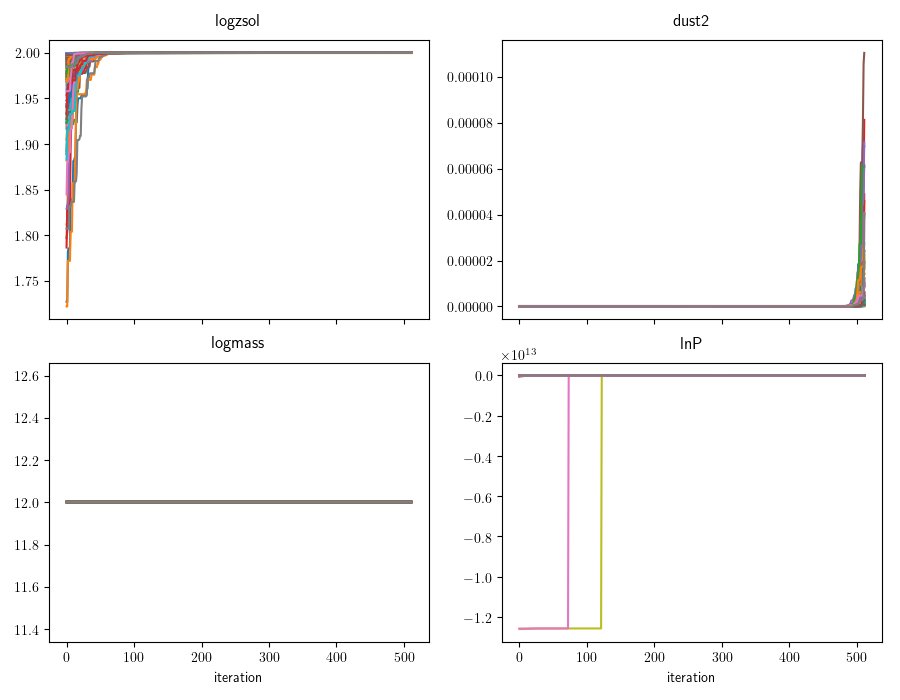

<IPython.core.display.Javascript object>


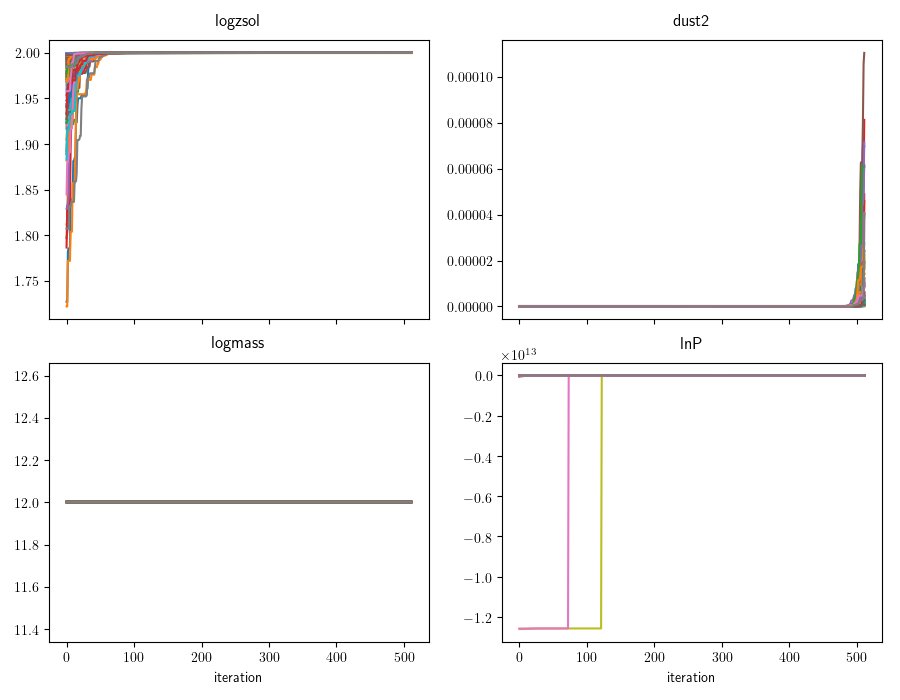

In [36]:
testres.show_walkers(showpars=["logzsol", "dust2", "logmass"])